## What’s This About 🤔
Welcome to *Finding NFL Winners*, a series where we dive into what it takes to predict **NFL game outcomes**. In this first part, *The Points*, we’ll explore the most common scores and examine how games are most likely to play out.

As the series unfolds, we’ll develop tools and eventually create a predictive model to answer the ultimate question: *Who’s going to win?* Let’s get started!

### Disclaimers

First, I’m relatively new to American football, with just three years of watching under my belt. While I still have plenty to learn, this fresh perspective allows me to focus solely on the numbers, free from bias.

Second, although I’ll reference Vegas odds in my analysis, I strongly discourage gambling. It’s addictive and harmful. This series is about understanding and predicting the game—not betting on it.

## CODE UTILS
---

In [1]:
from itables import show
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# Internals
from common.data_sources import *
from common.graph.plotly import *
from common.math import qcut_2d

Using png


In [2]:
# Import Data
nfl_df = get_nfl_pbp_data()

Cached True
nfl_pbp_data_df


In [3]:
# Transform
nfl_per_game_df = get_nfl_per_game_df(nfl_df)
nfl_per_game_per_team_df = get_nfl_offensive_per_game_per_team_df(nfl_df)
nfl_per_game_per_minute_df = get_nfl_per_game_per_minute_df(nfl_df)
nfl_per_game_per_qtr_df = get_nfl_per_game_per_qtr_df(nfl_df)
show(nfl_per_game_per_team_df)

## CONTENT
---

---
## Scores

According to the [NFL Rules](https://operations.nfl.com/the-rules/nfl-rulebook/): *"A team wins by having more points than its opponent after four quarters (60 minutes) or after overtime, if applicable"*. In simple terms, your offense just needs to score more points than the points your defense allow your opponent to score.

But how many points should my offense score to win, or how many points should my defense allow?

<div style="text-align: center;">
  <figure>
    <img src="article_assets/nfl_scores.webp" alt="Scores" style="max-height: 600px;">
    <figcaption>Wallpaper by shreallclark</figcaption>
  </figure>
</div>

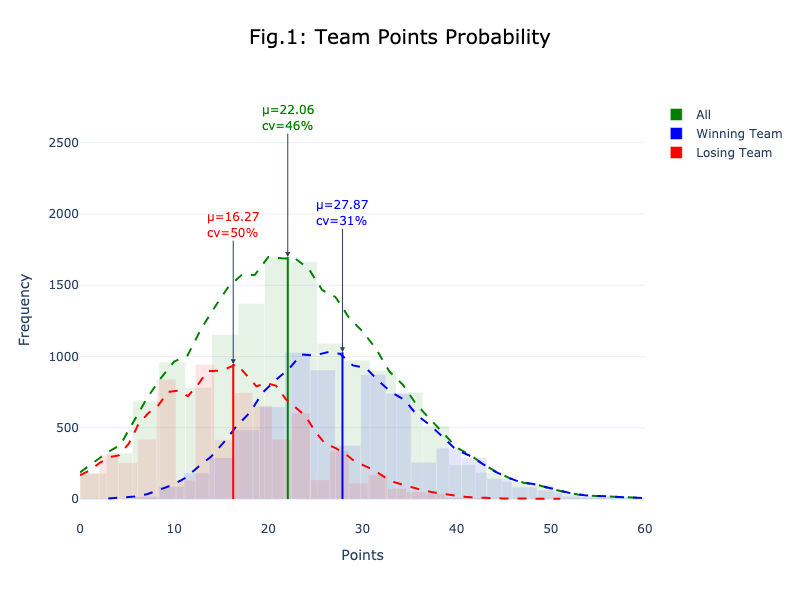

In [4]:
# Plot Histogram
# Data
score_data = nfl_per_game_per_team_df["posteam_score_post"].dropna()
winning_score_data = nfl_per_game_df["winning_team_score"].dropna()
losing_score_data = nfl_per_game_df["losing_team_score"].dropna()
# Figure
HIST_BINS = 25
fig = go.Figure()
plot_overlap_histogram(score_data, fig, bins=HIST_BINS, name="All", color="green")
plot_overlap_histogram(winning_score_data, fig, bins=HIST_BINS, name="Winning Team", color="blue")
plot_overlap_histogram(losing_score_data, fig, bins=HIST_BINS, name="Losing Team",color="red")
# Update layout
fig.update_layout(
    title=dict(text="Fig.1: Team Points Probability", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict(range=[0, 60], title="Points"),
    yaxis_title="Frequency",
    template="plotly_white",
    barmode="overlay"
)
# fig.write_image("figure1.png")
fig.show()

In [5]:
# Calculate Probability
w_m, w_std = winning_score_data.mean(), winning_score_data.std()
l_m, l_std = losing_score_data.mean(), losing_score_data.std()
w_lower_bound, w_higher_bound = round(w_m - w_std, 4), round(w_m + w_std, 4)
l_lower_bound, l_higher_bound = round(l_m - l_std, 4), round(l_m + l_std, 4)
total = nfl_per_game_df["winning_team_score"].count()
w_between_bound = nfl_per_game_df[
    (nfl_per_game_df["winning_team_score"] >= w_lower_bound) &
    (nfl_per_game_df["winning_team_score"] <= w_higher_bound)
]["winning_team_score"].count()
l_between_bound = nfl_per_game_df[
    (nfl_per_game_df["losing_team_score"] >= l_lower_bound) &
    (nfl_per_game_df["losing_team_score"] <= l_higher_bound)
]["losing_team_score"].count()
w_l_between_bound = nfl_per_game_df[
    (nfl_per_game_df["winning_team_score"] >= w_lower_bound) &
    (nfl_per_game_df["winning_team_score"] <= w_higher_bound) &
    (nfl_per_game_df["losing_team_score"] >= l_lower_bound) &
    (nfl_per_game_df["losing_team_score"] <= l_higher_bound)
]["losing_team_score"].count()
print(f"Probabily of winning team score between [{w_lower_bound}, {w_higher_bound}]: {round(100*w_between_bound/total, 2)}")
print(f"Probabily of losing team score between [{l_lower_bound}, {l_higher_bound}]: {round(100*l_between_bound/total, 2)}")
print(f"Probabily of winning and losing team score between bounds: {round(100*w_l_between_bound/total,2)}")

Probabily of winning team score between [19.1025, 36.6425]: 67.53
Probabily of losing team score between [8.1305, 24.4135]: 69.13
Probabily of winning and losing team score between bounds: 49.83


<br>

*Fig.1* shows the probability of all scores in NFL games from **1999 to 11/24/2024**. The average score for any team (winning or losing) is 22 points, while losing teams average 16 points and winning teams average 28 points. Almost **70% of winning team points fall between 19 and 36 points**, while **70% of losing team points fall between 8 and 24 points**.

Something relevant is that the coefficient of variation of the losing team is over 50%, which means *losing scores are very volatile*. Even when they have an average of 16, they are very likely to range from 8 to 24. And **why don't winning teams behave like this?** 🤔 Let's save this one for later analysis.

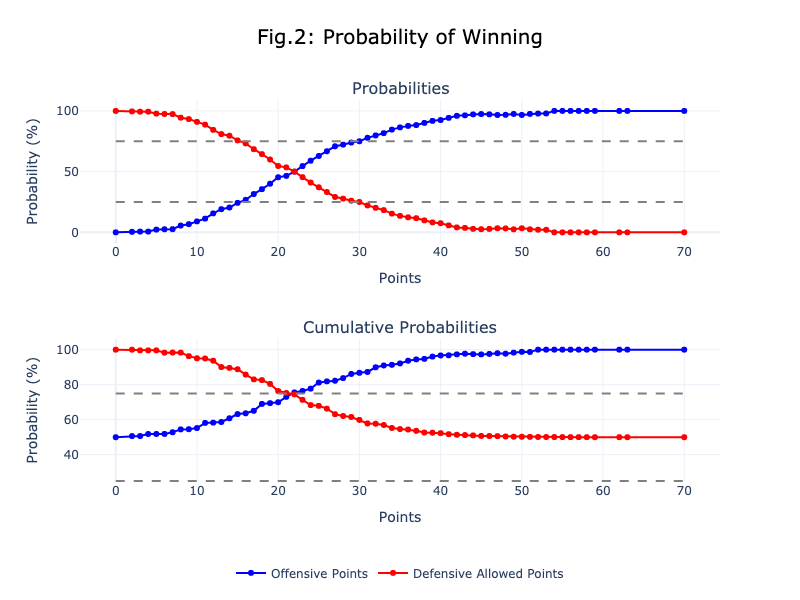

In [6]:
thresholds = sorted(set(nfl_per_game_df["winning_team_score"].unique()) | set(nfl_per_game_df["losing_team_score"].unique()))
bin = 2

off_higher_prob, off_higher_cum_prob, def_lower_prob, def_lower_cum_prob = [], [], [], []
for threshold in thresholds:
    # Offense
    off_higher_wins = len(nfl_per_game_df[(nfl_per_game_df["winning_team_score"] >= threshold - bin) & (nfl_per_game_df["winning_team_score"] < threshold + bin)])
    off_higher_losses = len(nfl_per_game_df[(nfl_per_game_df["losing_team_score"] >= threshold - bin) & (nfl_per_game_df["losing_team_score"] < threshold + bin)])
    off_higher_cases = off_higher_wins + off_higher_losses
    off_higher_prob.append(off_higher_wins * 100 / off_higher_cases if off_higher_cases > 0 else 0)
    # Cumulative
    off_higher_cum_wins = len(nfl_per_game_df[(nfl_per_game_df["winning_team_score"] >= threshold)])
    off_higher_cum_losses = len(nfl_per_game_df[(nfl_per_game_df["losing_team_score"] >= threshold)])
    off_higher_cum_cases = off_higher_cum_wins + off_higher_cum_losses
    off_higher_cum_prob.append(off_higher_cum_wins * 100 / off_higher_cum_cases if off_higher_cum_cases > 0 else 0)
    # Defense
    def_lower_wins = len(nfl_per_game_df[(nfl_per_game_df["losing_team_score"] >= threshold - bin) & (nfl_per_game_df["losing_team_score"] < threshold + bin)])
    def_lower_loss = len(nfl_per_game_df[(nfl_per_game_df["winning_team_score"] >= threshold - bin) & (nfl_per_game_df["winning_team_score"] < threshold + bin)])
    def_lower_cases = def_lower_wins + def_lower_loss
    def_lower_prob.append(def_lower_wins * 100 / def_lower_cases if def_lower_cases > 0 else 0)
    # Cumulative
    def_lower_cum_wins = len(nfl_per_game_df[(nfl_per_game_df["losing_team_score"] <= threshold)])
    def_lower_cum_loss = len(nfl_per_game_df[nfl_per_game_df["winning_team_score"] <= threshold])
    def_lower_cum_cases = def_lower_cum_wins + def_lower_cum_loss
    def_lower_cum_prob.append(def_lower_cum_wins * 100 / def_lower_cum_cases if def_lower_cum_cases > 0 else 0)

cumulative_prob_df = pd.DataFrame({
    "Threshold": thresholds,
    "off_higher_prob": off_higher_prob,
    "def_lower_prob": def_lower_prob,
    "off_higher_cum_prob": off_higher_cum_prob,
    "def_lower_cum_prob": def_lower_cum_prob
})

fig = make_subplots(rows=2, cols=1, subplot_titles=("Probabilities", "Cumulative Probabilities"))

fig.add_traces([
    go.Scatter(x=cumulative_prob_df["Threshold"], y=cumulative_prob_df["off_higher_prob"], mode="lines+markers", name="Offensive Points", line=dict(color="blue")),
    go.Scatter(x=cumulative_prob_df["Threshold"], y=cumulative_prob_df["def_lower_prob"], mode="lines+markers", name="Defensive Allowed Points", line=dict(color="red")),
    go.Scatter(x=cumulative_prob_df["Threshold"], y=cumulative_prob_df["off_higher_cum_prob"], mode="lines+markers", name="Offensive Cumulative", line=dict(color="blue"), showlegend=False),
    go.Scatter(x=cumulative_prob_df["Threshold"], y=cumulative_prob_df["def_lower_cum_prob"], mode="lines+markers", name="Defensive Allowed Points", line=dict(color="red"), showlegend=False)
], rows=[1, 1, 2, 2], cols=[1, 1, 1, 1])

for row in (1, 2):
    for y in (25, 75):
        fig.add_shape(type="line", x0=thresholds[0], x1=thresholds[-1], y0=y, y1=y, line=dict(color="gray", dash="dash"), col=1, row=row)

fig.update_layout(
    title=dict(text="Fig.2: Probability of Winning", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict(title="Points", showgrid=True),
    xaxis2=dict(title="Points", showgrid=True),
    yaxis=dict(title="Probability (%)", showgrid=True),
    yaxis2=dict(title="Probability (%)", showgrid=True),
    template="plotly_white",
    showlegend=True,
    legend=dict(orientation="h", yanchor="top", y=-0.2, xanchor="center", x=0.5)
)

fig.show()

On *Fig. 2*, we can see the probability of a team winning based on its offensive points or defensive points allowed, for both each value and the cumulative. Here it is interesting to highlight that if **you score exactly 22 points or allow 22 points, you have a 50% chance of winning**. Additionally, teams scoring **22 or more have a 75% chance of winning**, and teams allowing **22 or fewer points have a 75% chance of winning**.

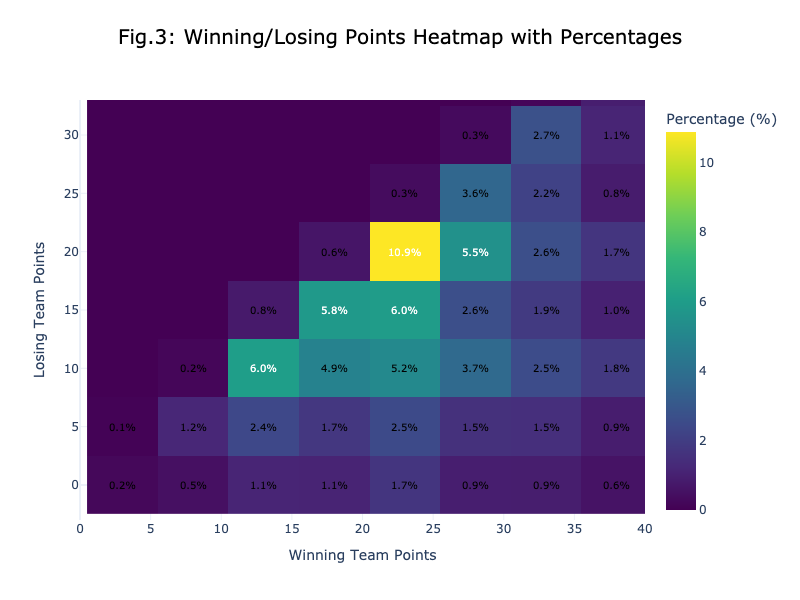

In [7]:
RANGE_SIZE = 5
x_bins = np.arange(nfl_per_game_df["winning_team_score"].min(), nfl_per_game_df["winning_team_score"].max() + 1, RANGE_SIZE)
y_bins = np.arange(nfl_per_game_df["losing_team_score"].min(), nfl_per_game_df["losing_team_score"].max() + 1, RANGE_SIZE)
hist, x_edges, y_edges = np.histogram2d(
    nfl_per_game_df["winning_team_score"], nfl_per_game_df["losing_team_score"], bins=[x_bins, y_bins]
)

hist_percentage = hist / hist.sum() * 100

heatmap = go.Heatmap(
    z=hist_percentage.T, x=x_bins[:-1], y=y_bins[:-1],
    colorscale="Viridis", colorbar=dict(title="Percentage (%)")
)

annotations = [
    go.layout.Annotation(
        text=f"{hist_percentage[j, i]:.1f}%",
        x=x, y=y, showarrow=False,
        font=dict(size=10, color="white" if hist_percentage[j, i] > hist_percentage.max() / 2 else "black")
    )
    for i, y in enumerate(y_bins[:-1])
    for j, x in enumerate(x_bins[:-1])
    if hist_percentage[j, i] > 0
]

fig = go.Figure(data=[heatmap])
fig.update_layout(
    title=dict(text="Fig.3: Winning/Losing Points Heatmap with Percentages", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict(title="Winning Team Points", range=[0, 40]),
    yaxis=dict(title="Losing Team Points", range=[-3, 33]),
    annotations=annotations,
    template="plotly_white",
)
fig.show()

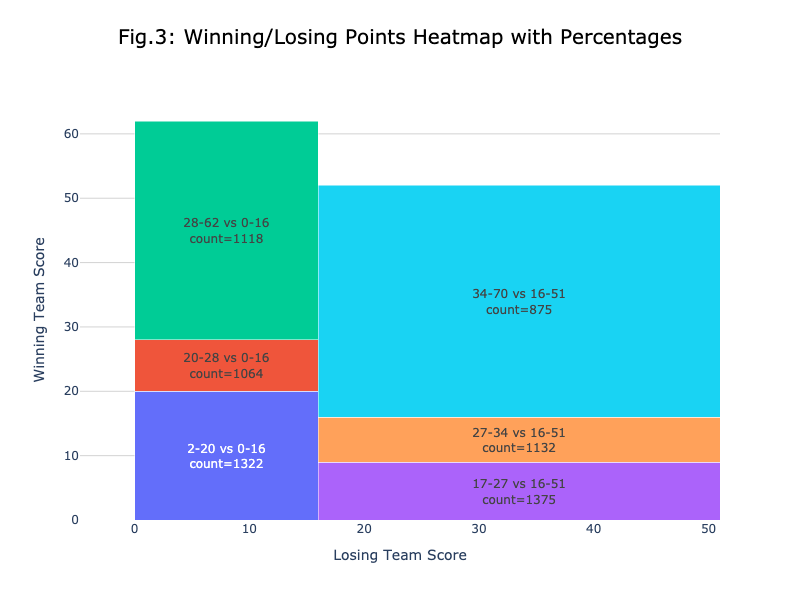

In [8]:
total = len(nfl_per_game_df["winning_team_score"])
edges = qcut_2d(nfl_per_game_df, "losing_team_score", "winning_team_score", qx=2, qy=3)

data = []
for i, (x_bin, y_bin) in enumerate(edges):
    data.append({
        "name": f"{int(y_bin[0].left)}-{int(y_bin[0].right)} vs {int(x_bin[0].left)}-{int(x_bin[0].right)}",
        "x": int(x_bin[0].left),
        "y": int(y_bin[0].right),
        "count": y_bin[1],
        "xwidth": int(x_bin[0].right - x_bin[0].left),
        "ywidth": y_bin[0].right if i == 0 else int(y_bin[0].right - y_bin[0].left),
        "xcenter": (x_bin[0].left + x_bin[0].right) / 2,
    })

df = pd.DataFrame(data)

fig = go.Figure()

for _, row in df.iterrows():
    fig.add_trace(go.Bar(
        x=[row["xcenter"]],
        y=[row["ywidth"]],
        width=[row["xwidth"]],
        name=row["name"],
        text=f"{row['name']}<br>count={row['count']}",
        textposition="inside",
        insidetextanchor="middle",
        showlegend=False
    ))

fig.update_layout(
    title=dict(text="Fig.3: Winning/Losing Points Heatmap with Percentages", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict(title="Losing Team Score"),
    yaxis=dict(title="Winning Team Score", showgrid=True, gridcolor="lightgray", zeroline=False),
    barmode="stack",
    template="plotly_white",
    showlegend=False
)

fig.show()

On *Fig. 3*, we can see a heatmap of winning team points versus losing team points. It highlights that the range (23–28) for winning teams versus (20–25) for losing teams is the most common occurrence, with over 10% of scores being in that range. Additionally, the most frequent scores are 23–20 (130 occurrences), 20–17 (128 occurrences), and 27–24 (120 occurrences). We can see a pattern that maybe closed games tend to be more common? Let's take a look to the spread.

### Scores and the Spread

According to [ESPN's Sport Betting](https://www.espn.com/espn/betting/story/_/id/38897025/sports-betting-glossary-odds-lines-spreads-futures-more):
* **Point Spread**: ESPN defines the point spread as the number of points by which the favored team is expected to win over the underdog. Bettors wager on whether the favorite will win by more than the spread or if the underdog will lose by less than the spread or win outright.
* **Total (Over/Under)**: The total is the expected combined point total of both teams in a game. Bettors can wager on whether the actual combined score will be over or under this set number.

So, in simple terms, the spread is the difference between the winning team’s score and the losing team’s score, while the total is the combined score of both teams.

<div style="text-align: center;">
  <figure>
    <img src="article_assets/nfl_spreads.jpg" alt="Spreads" style="max-height: 600px;">
    <figcaption>Cooper Neill | Credit: Getty Images</figcaption>
  </figure>
</div>


Let's do a similar analysis and first take to the distribution of the totals.

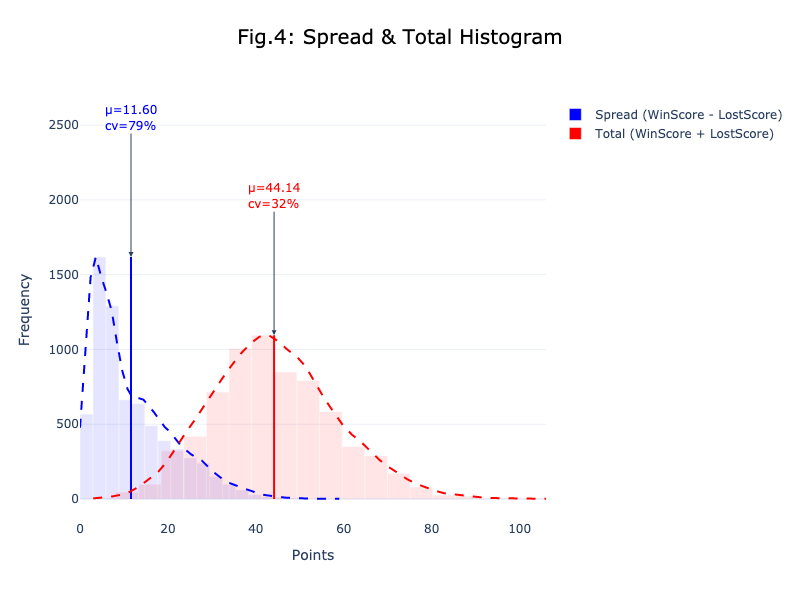

In [9]:
HIST_BINS = 20
fig = go.Figure()
plot_overlap_histogram(nfl_per_game_df["score_diff"], fig, bins=HIST_BINS, name="Spread (WinScore - LostScore)", color="blue")
plot_overlap_histogram(nfl_per_game_df["score_total"], fig, bins=HIST_BINS, name="Total (WinScore + LostScore)", color="red")

fig.update_layout(
    title=dict(text="Fig.4: Spread & Total Histogram", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict(title="Points"),
    yaxis_title="Frequency",
    template="plotly_white",
    barmode="overlay"
)

fig.show()

In [10]:
lower_bound, higher_bound = 3, 8
total = nfl_per_game_df["score_diff"].count()
between_bound = nfl_per_game_df[(nfl_per_game_df["score_diff"] >= lower_bound) & (nfl_per_game_df["score_diff"] <= higher_bound)]["score_diff"].count()

print("min_score_diff:", nfl_per_game_df["score_diff"].min(), "max_score_diff:", nfl_per_game_df["score_diff"].max())
print(f"Probability of score_diff between [{lower_bound}, {higher_bound}]: {round(100 * between_bound / total, 2)}%")

min_score_diff: 0.0 max_score_diff: 59.0
Probability of score_diff between [3, 8]: 42.26%


As we see in *Fig. 4*, spreads are highly dispersed, ranging from 0 points to 59 points. Notably, there is a high concentration between 3 and 8 points, with 42% of games having a spread within this range. Now let's trade to equally divide the spread.

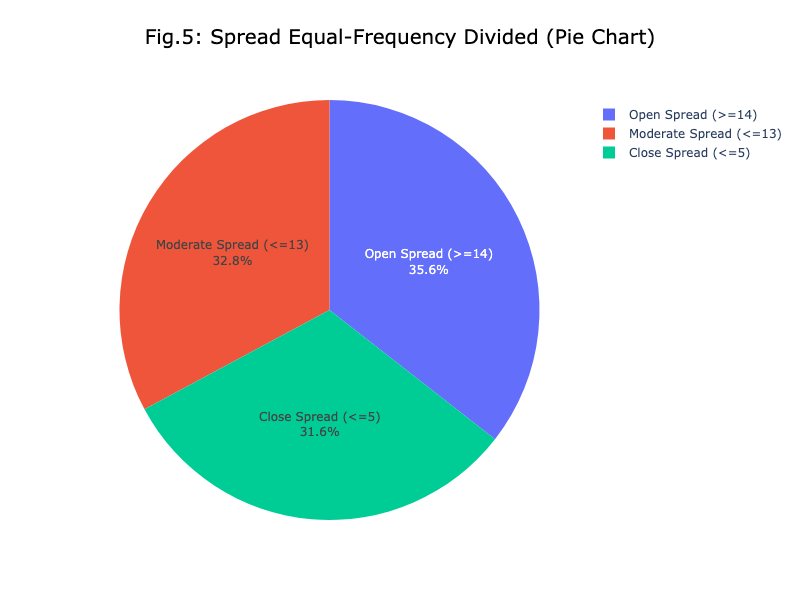

In [11]:
num_bins = 3
data = nfl_per_game_df['score_diff'].reset_index()
win_bin_edges = [0, 5, 13, 60]
data['score_diff_bin'] = pd.cut(data['score_diff'], bins=win_bin_edges, labels=["Close Spread (<=5)", "Moderate Spread (<=13)", "Open Spread (>=14)"])
bin_counts = data['score_diff_bin'].value_counts(sort=False)

fig = go.Figure(go.Pie(
    labels=[str(interval) for interval in bin_counts.index],
    values=bin_counts.values,
    textinfo='percent+label',
    hoverinfo='label+value'
))
fig.update_layout(
    title=dict(text="Fig.5: Spread Equal-Frequency Divided (Pie Chart)", x=0.5, y=0.95, font=dict(size=20, color="black")),
    template="plotly_white"
)
fig.show()

Then, **games are equally divided into 3 spread groups: close-spread, moderate-spread, and open-spread games**:
* **Close Spread**: Where the score difference is between 0-5 points.
* **Moderate Spread**: Where the score difference is between 6-13 points.
* **Open Spread**: Where the score difference is higher than 14 points.

Now, let's check how the winning teams are distributed among these spread buckets.

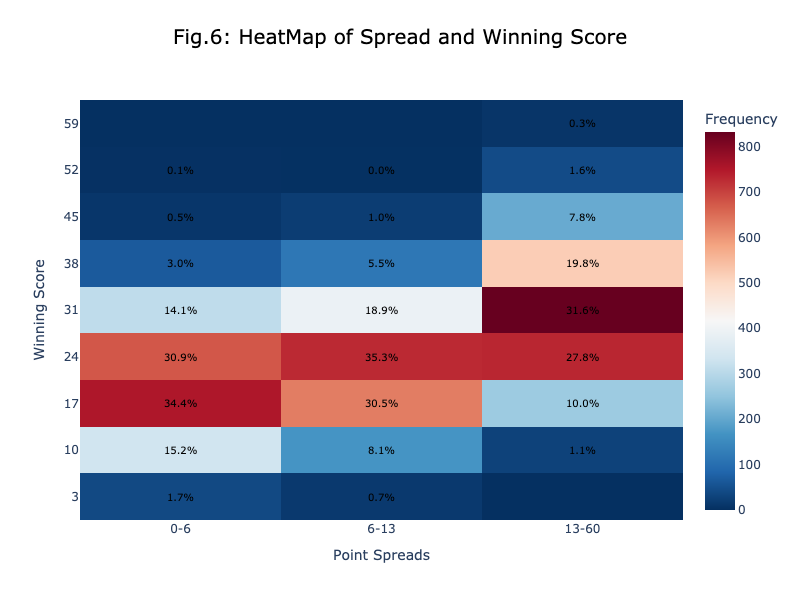

In [12]:
score_diff_bins = [0, 6, 13, 60]
filtered_df = nfl_per_game_df[(nfl_per_game_df["score_diff"] >= 0) & (nfl_per_game_df["score_diff"] <= 60)]
x_bins = np.array(score_diff_bins)
y_bins = np.arange(filtered_df["winning_team_score"].min(), filtered_df["winning_team_score"].max() + 1, 7)
hist, x_edges, y_edges = np.histogram2d(filtered_df["score_diff"], filtered_df["winning_team_score"], bins=[x_bins, y_bins])
x_bin_totals = hist.sum(axis=1, keepdims=True)
hist_percentages = np.divide(hist, x_bin_totals, where=x_bin_totals != 0) * 100

heatmap = go.Heatmap(
    z=hist.T,
    x=[f"{x_bins[i]}-{x_bins[i+1]}" for i in range(len(x_bins)-1)],
    y=y_bins[:-1],
    colorscale="RdBu",
    reversescale=True,
    colorbar=dict(title="Frequency")
)
annotations = [
    dict(x=f"{x_bins[i]}-{x_bins[i+1]}", y=y_bins[j], text=f"{hist_percentages[i, j]:.1f}%", showarrow=False, font=dict(size=10, color="black"))
    for i in range(len(x_bins)-1) for j in range(len(y_bins)-1) if hist_percentages[i, j] > 0
]
fig = go.Figure(data=[heatmap])
fig.update_layout(
    title=dict(text="Fig.6: HeatMap of Spread and Winning Score", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict(title="Point Spreads"),
    yaxis=dict(title="Winning Score", tickvals=y_bins),
    template="plotly_white",
    annotations=annotations
)
fig.show()

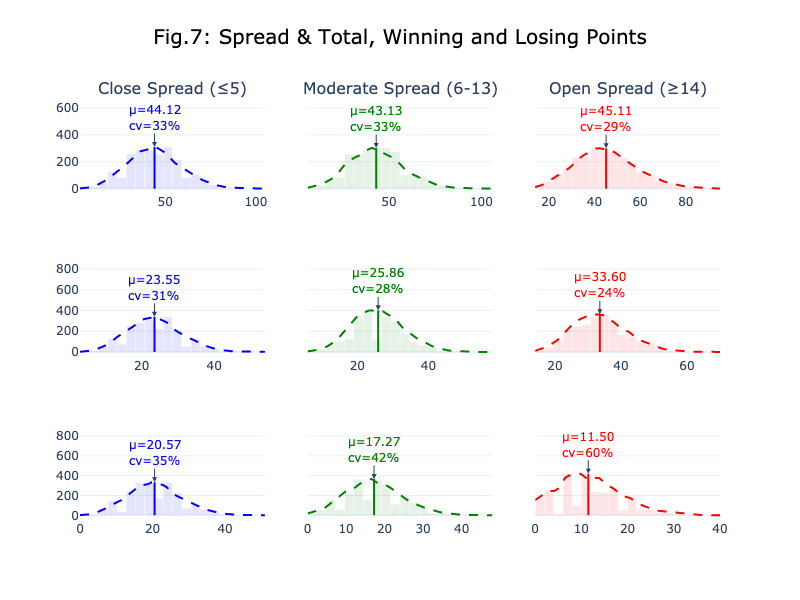

In [13]:
# Data
nfl_per_game_df_low_spread = nfl_per_game_df[nfl_per_game_df["score_diff"] <= 5]
nfl_per_game_df_moderate_spread = nfl_per_game_df[(nfl_per_game_df["score_diff"] >= 6) & (nfl_per_game_df["score_diff"] <= 13)]
nfl_per_game_df_high_spread = nfl_per_game_df[nfl_per_game_df["score_diff"] >=14]
# Figure
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=("Close Spread (≤5)", "Moderate Spread (6-13)", "Open Spread (≥14)"),
    shared_yaxes=True
)
plot_overlap_histogram(nfl_per_game_df_low_spread["score_total"], fig, bins=HIST_BINS, name="Close Spread", color="blue", row=1, col=1, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_moderate_spread["score_total"], fig, bins=HIST_BINS, name="Medium Spread", color="green", row=1, col=2, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_high_spread["score_total"], fig, bins=HIST_BINS, name="Open Spread", color="red", row=1, col=3, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_low_spread["winning_team_score"], fig, bins=HIST_BINS, name="Close Spread", color="blue", row=2, col=1, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_moderate_spread["winning_team_score"], fig, bins=HIST_BINS, name="Medium Spread", color="green", row=2, col=2, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_high_spread["winning_team_score"], fig, bins=HIST_BINS, name="Open Spread", color="red", row=2, col=3, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_low_spread["losing_team_score"], fig, bins=HIST_BINS, name="Close Spread", color="blue", row=3, col=1, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_moderate_spread["losing_team_score"], fig, bins=HIST_BINS, name="Medium Spread", color="green", row=3, col=2, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_high_spread["losing_team_score"], fig, bins=HIST_BINS, name="Open Spread", color="red", row=3, col=3, ay=-30, max_row=3)
fig.update_layout(
    title=dict(text="Fig.7: Spread & Total, Winning and Losing Points", x=0.5, y=0.95, font=dict(size=20, color="black")),
    template="plotly_white",
    showlegend=False
)
fig.show()

As *Fig. 6* and *Fig. 7* show:
- **Closed-Spread Games**: The average score of the winning team is **23–24**, while the losing team scores about **20–21**. The winning team has almost **65% chance** of scoring between **17–30**.
- **Moderate-Spread Games**: The average score of the winning team is **25–26**, while the losing team scores about **17**, but it is highly volatile. The winning team has almost **66% chance** of scoring between **17–30**, with a mean of **25**.
- **Open-Spread Games**: The average score of the winning team is **33–34**, while the losing team scores about **11–12**, but it is highly volatile. The winning team has almost **60% chance** of scoring between **24–37**, with a mean of **33**.

## Scores and the Time

An NFL game lasts **60 minutes** (4 quarters of 15 minutes). How do scores change as time progresses? Let's see if we can identify any patterns.

<div style="text-align: center;">
  <figure>
    <img src="article_assets/nfl_scores_time.jpg" alt="Spreads" style="max-height: 600px;">
    <figcaption>Tyler Schank | Credit: Getty Images</figcaption>
  </figure>
</div>

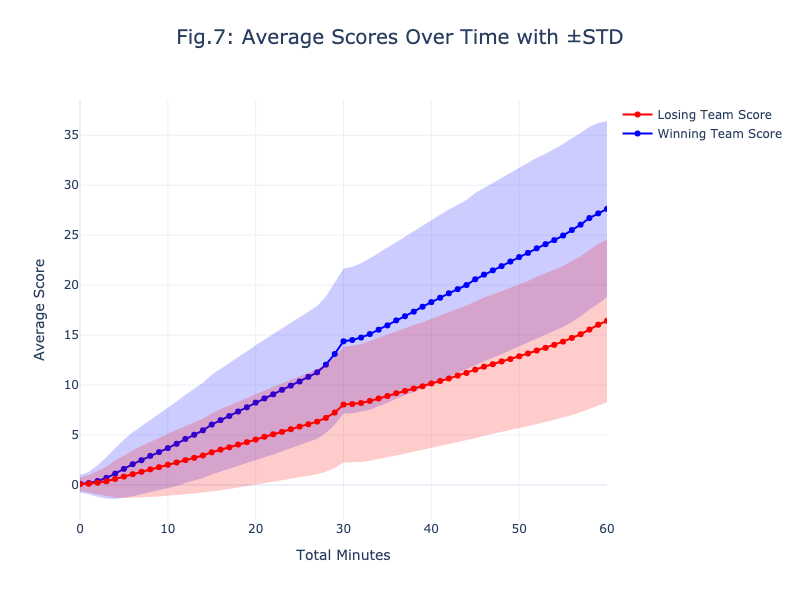

In [14]:
def plot_stat_over_time(fig, df, col, color="blue", name=None, plot_std=True):
    stats = df.groupby("total_minutes_rounded")[col].agg(["mean", "std"]).reset_index()
    stats.columns = ["total_minutes_rounded", f"{col}_mean", f"{col}_std"]
    stats = stats[stats["total_minutes_rounded"] <= 60]
    fig.add_trace(go.Scatter(x=stats["total_minutes_rounded"], y=stats[f"{col}_mean"], mode="lines+markers", name=name, line=dict(color=color)))
    if plot_std:
        fig.add_trace(go.Scatter(x=stats["total_minutes_rounded"], y=stats[f"{col}_mean"] + stats[f"{col}_std"], mode="lines", line=dict(width=0), showlegend=False))
        fig.add_trace(go.Scatter(x=stats["total_minutes_rounded"], y=stats[f"{col}_mean"] - stats[f"{col}_std"], mode="lines", line=dict(width=0), showlegend=False, fill="tonexty", fillcolor=f"rgba(0, 0, 255, 0.2)" if color == "blue" else f"rgba(255, 0, 0, 0.2)"))

fig = go.Figure()
plot_stat_over_time(fig, nfl_per_game_per_minute_df, col="winning_team_score", name="Winning Team Score")
plot_stat_over_time(fig, nfl_per_game_per_minute_df, col="losing_team_score", name="Losing Team Score", color="red")
fig.update_layout(
    title=dict(text="Fig.7: Average Scores Over Time with ±STD", x=0.5, y=0.95, font=dict(size=20)),
    xaxis=dict(title="Total Minutes", range=[0, 60]),
    yaxis=dict(title="Average Score"),
    template="plotly_white"
)
fig.show()

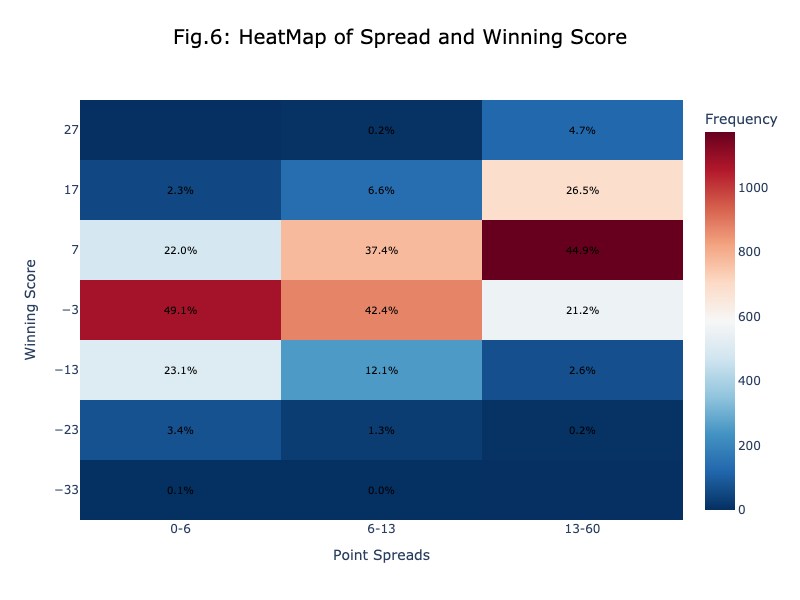

In [15]:
nfl_per_game_per_minute_low_spread_df = nfl_per_game_per_minute_df[nfl_per_game_per_minute_df["score_diff_total"] <= 5]
nfl_per_game_per_minute_moderate_spread = nfl_per_game_per_minute_df[(nfl_per_game_per_minute_df["score_diff_total"] >= 6) & (nfl_per_game_per_minute_df["score_diff_total"] <= 13)]
nfl_per_game_per_minute_high_spread = nfl_per_game_per_minute_df[nfl_per_game_per_minute_df["score_diff_total"] >=14]

score_diff_bins = [0, 6, 13, 60]
filtered_df = nfl_per_game_per_minute_df[nfl_per_game_per_minute_df["total_minutes_rounded"] == 30]
x_bins = np.array(score_diff_bins)
y_bins = np.arange(filtered_df["score_diff"].min(), filtered_df["score_diff"].max() + 1, 10)
hist, x_edges, y_edges = np.histogram2d(filtered_df["score_diff_total"], filtered_df["score_diff"], bins=[x_bins, y_bins])
x_bin_totals = hist.sum(axis=1, keepdims=True)
hist_percentages = np.divide(hist, x_bin_totals, where=x_bin_totals != 0) * 100

heatmap = go.Heatmap(
    z=hist.T,
    x=[f"{x_bins[i]}-{x_bins[i+1]}" for i in range(len(x_bins)-1)],
    y=y_bins[:-1],
    colorscale="RdBu",
    reversescale=True,
    colorbar=dict(title="Frequency")
)
annotations = [
    dict(x=f"{x_bins[i]}-{x_bins[i+1]}", y=y_bins[j], text=f"{hist_percentages[i, j]:.1f}%", showarrow=False, font=dict(size=10, color="black"))
    for i in range(len(x_bins)-1) for j in range(len(y_bins)-1) if hist_percentages[i, j] > 0
]
fig = go.Figure(data=[heatmap])
fig.update_layout(
    title=dict(text="Fig.6: HeatMap of Spread and Winning Score", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict(title="Point Spreads"),
    yaxis=dict(title="Winning Score", tickvals=y_bins),
    template="plotly_white",
    annotations=annotations
)
fig.show()


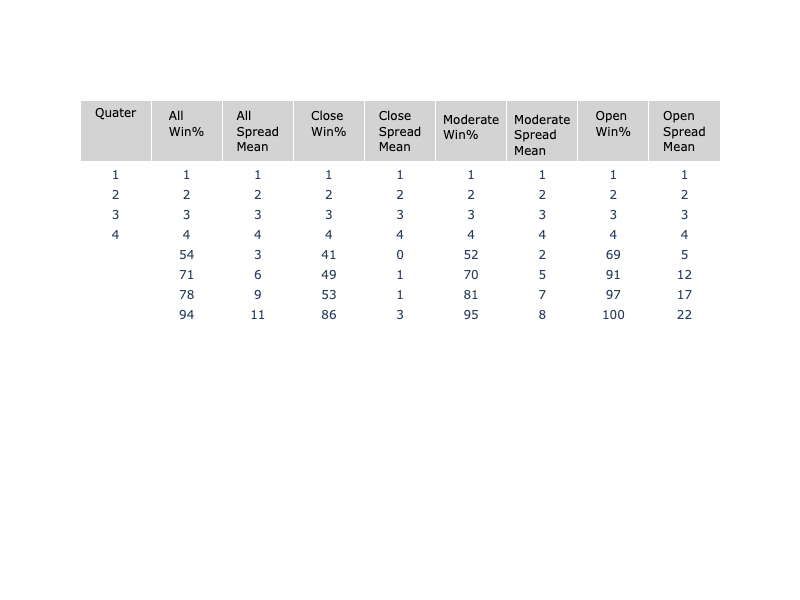

In [16]:
data = {qtr: [1, 2, 3, 4] for qtr in ["Quater", "All Win%", "All Spread Mean", "Close Win%", "Close Spread Mean", "Moderate Win%", "Moderate Spread Mean", "Open Win%", "Open Spread Mean"]}

for name, df in [
    ("All", nfl_per_game_per_qtr_df),
    ("Close", nfl_per_game_per_qtr_df[nfl_per_game_per_qtr_df["score_diff_total"] <= 5]),
    ("Moderate", nfl_per_game_per_qtr_df[(nfl_per_game_per_qtr_df["score_diff_total"] >= 6) & (nfl_per_game_per_qtr_df["score_diff_total"] <= 13)]),
    ("Open", nfl_per_game_per_qtr_df[nfl_per_game_per_qtr_df["score_diff_total"] >= 14]),
]:
    for qtr in [1, 2, 3, 4]:
        f_df = df[df["qtr"] == qtr]
        wins, total = len(f_df[(f_df["score_diff"] > 0) & (f_df["score_diff_total"] > 0)]), len(f_df)
        data[f"{name} Win%"].append(round(wins * 100 / total))
        data[f"{name} Spread Mean"].append(round(f_df["score_diff"].mean()))

fig = go.Figure(data=[go.Table(
    header=dict(values=list(data.keys()), fill_color="lightgray", align="center", font=dict(size=12, color="black")),
    cells=dict(values=list(data.values()), fill_color="white", align="center", font=dict(size=12))
)])
fig.show()

## Scores predicting Scores

In [25]:
nfl_by_team_df = get_nfl_offensive_per_game_per_team_df(nfl_df)
nfl_by_team_df["team"] = nfl_by_team_df["posteam"]
nfl_by_team_df[["opponent_team", "offense_points", "defense_allowed_points"]] = nfl_by_team_df.apply(
    lambda row: pd.Series({
        "opponent_team": row["away_team"] if row["posteam_type"] == "home" else row["home_team"],
        "offense_points": row["home_score"] if row["posteam_type"] == "home" else row["away_score"],
        "defense_allowed_points": row["away_score"] if row["posteam_type"] == "home" else row["home_score"],
    }), axis=1
)
nfl_by_team_df["team_diff"] = nfl_by_team_df["offense_points"] - nfl_by_team_df["defense_allowed_points"]
nfl_by_team_df["is_winner"] = nfl_by_team_df.apply(lambda row: "True" if row["offense_points"] > row["defense_allowed_points"] else "False", axis=1)

In [27]:
filter_df = nfl_by_team_df[["team", "opponent_team", "posteam_type", "season", "week", "offense_points", "defense_allowed_points", "team_diff", "is_winner"]].copy()
filter_df = filter_df.sort_values(by=['season', 'week', 'team']).reset_index(drop=True)

off_mapping = filter_df.set_index(['season', 'week', 'team'])['offense_points']
def_mapping = filter_df.set_index(['season', 'week', 'team'])['defense_allowed_points']
# Apply lagging: map opponent team and season to defense points and shift by 1


# Add a lagged column for the opponent's defense points
for lag in range(1, 7):
    filter_df[f'prev_offense_points_{lag}'] = filter_df.groupby(["team", "season"])['offense_points'].shift(lag)
    filter_df[f'prev_defense_allowed_points_{lag}'] = filter_df.groupby(["team", "season"])['defense_allowed_points'].shift(lag)
    filter_df[f'prev_opponent_defense_allowed_points_{lag}'] = filter_df.apply(
        lambda row: def_mapping.get((row['season'], row['week'] - lag, row['opponent_team']), None),
        axis=1
    )
    filter_df[f'prev_opponent_offense_points_{lag}'] = filter_df.apply(
        lambda row: off_mapping.get((row['season'], row['week'] - lag, row['opponent_team']), None),
        axis=1
    )

# filter_df
# filter_df.corr()["offense_points"].abs()

df_dict = filter_df.head(5).to_dict(orient="list")  # Convert rows to lists
print(df_dict)

df_dict = nfl_per_game_per_qtr_df.head(5).to_dict(orient="list")  # Convert rows to lists
print(df_dict)

{'team': ['ARI', 'ATL', 'BUF', 'CAR', 'CHI'], 'opponent_team': ['PHI', 'MIN', 'IND', 'NO', 'KC'], 'posteam_type': ['away', 'home', 'away', 'away', 'home'], 'season': [1999, 1999, 1999, 1999, 1999], 'week': [1, 1, 1, 1, 1], 'offense_points': [25, 14, 14, 10, 20], 'defense_allowed_points': [24, 17, 31, 19, 17], 'team_diff': [1, -3, -17, -9, 3], 'is_winner': ['True', 'False', 'False', 'False', 'True'], 'prev_offense_points_1': [nan, nan, nan, nan, nan], 'prev_defense_allowed_points_1': [nan, nan, nan, nan, nan], 'prev_opponent_defense_allowed_points_1': [nan, nan, nan, nan, nan], 'prev_opponent_offense_points_1': [nan, nan, nan, nan, nan], 'prev_offense_points_2': [nan, nan, nan, nan, nan], 'prev_defense_allowed_points_2': [nan, nan, nan, nan, nan], 'prev_opponent_defense_allowed_points_2': [nan, nan, nan, nan, nan], 'prev_opponent_offense_points_2': [nan, nan, nan, nan, nan], 'prev_offense_points_3': [nan, nan, nan, nan, nan], 'prev_defense_allowed_points_3': [nan, nan, nan, nan, nan], '

In [19]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_text
import graphviz


# Target and Features

df = filter_df.copy()
target = 'is_winner'
features = [
    col for col in df.columns if col.startswith("prev_")
]
df[features] = SimpleImputer(strategy='mean').fit_transform(df[features])
df[target] = LabelEncoder().fit_transform(df[target])
X = df[features]
y = df[target]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize and run GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Refit with the best estimator
best_dt = grid_search.best_estimator_
best_dt.fit(X_train, y_train)

# Export the decision tree to DOT format
dot_data = export_graphviz(
    best_dt,  # Trained decision tree model
    out_file=None,
    feature_names=X_train.columns,  # Feature names
    class_names=["away", "home"],  # Class names
    filled=True,  # Fill nodes with colors
    rounded=True,  # Rounded corners for nodes
    special_characters=True
)

# Render the DOT file to an image
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="png", cleanup=True)  # Save as PNG
graph.view()  # Open the image in the default viewer

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Accuracy: 0.5476993095539575


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.448415 to fit


'decision_tree.pdf'

### How Do You Make Points?

Teams can score points through several methods:
* Touchdown (6 points).
* Extra Point (1 point)
* Two-Point Conversion (2 points)
* Field Goal (3 points)
* Safety (2 points)

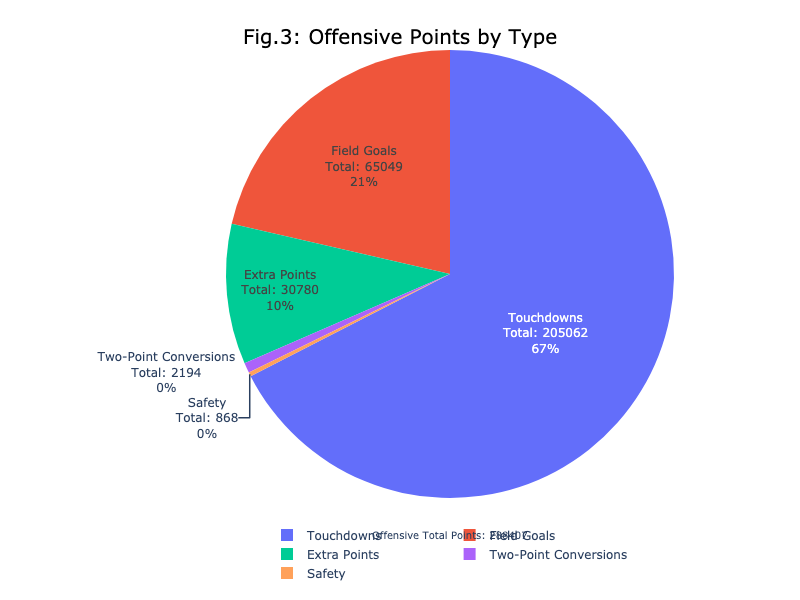

In [20]:
filtered_sum = nfl_per_game_per_team_df[["touchdown", "extra_point_count", "two_point_conv_count", "field_goal_count", "posteam_score_diff", "safety"]].sum()
adjusted_values = {
    "Touchdowns": 6 * filtered_sum["touchdown"],
    "Extra Points": filtered_sum["extra_point_count"],
    "Two-Point Conversions": 2* filtered_sum["two_point_conv_count"],
    "Field Goals": 3*filtered_sum["field_goal_count"],
    "Safety": 2*filtered_sum["safety"],
}
labels = list(adjusted_values.keys())
values = list(adjusted_values.values())
percentages = [f"{int(v* 100 / sum(values)) }%" for v in values]
total = filtered_sum["posteam_score_diff"]

# Figure
custom_text = [f"{labels[i]}<br>Total: {int(values[i])}<br>{percentages[i]}"for i in range(len(values))]
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    text=custom_text,  # Custom annotations inside the pie
    textinfo="text",   # Show custom text instead of default
    hoverinfo="label+percent+value"  # Show label, percent, and value on hover
)])
fig.update_layout(
    title=dict(text="Fig.3: Offensive Points by Type", x=0.5, y=0.95, font=dict(size=20, color="black")),
    annotations=[
        dict(
            x=0.5, y=-0.1,  # Annotation position
            text=f"Offensive Total Points: {int(total)}",
            showarrow=False,
            font=dict(size=10),
            align="center",
        )
    ],
    margin=dict(t=50, b=50) ,
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",  # Aligns the top of the legend
        y=-0.2,  # Places the legend below the chart
        xanchor="center",  # Centers the legend
        x=0.5  # Centers the legend horizontally
    )
)
fig.show()

In [21]:
absolute_corr = (
    nfl_per_game_per_team_df.corr()["posteam_score_diff"]
    .abs()
    .sort_values(ascending=False)
)
absolute_corr

/var/folders/cf/dh24jd9d5dg2grz6xlnygf_c0000gp/T/ipykernel_73827/3721691671.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



posteam_score_play_diff     1.000000
posteam_score_post          0.966332
touchdown                   0.875595
extra_point_count           0.840047
score_differential_post     0.685659
score_total                 0.682255
yards_gained                0.680760
pass_touchdown              0.679920
losing_team_score           0.576866
losing_team_score_total     0.576396
winning_team_score_total    0.567211
winning_team_score          0.562302
rush_touchdown              0.541570
home_score                  0.479923
away_score                  0.469191
third_down_failed           0.453326
receiving_yards             0.439895
passing_yards               0.439623
first_down_pass             0.418806
first_down_rush             0.418196
rushing_yards               0.399092
rush_attempt                0.392118
sack                        0.325126
third_down_converted        0.324343
fourth_down_failed          0.316515
interception                0.285139
incomplete_pass             0.267065
y

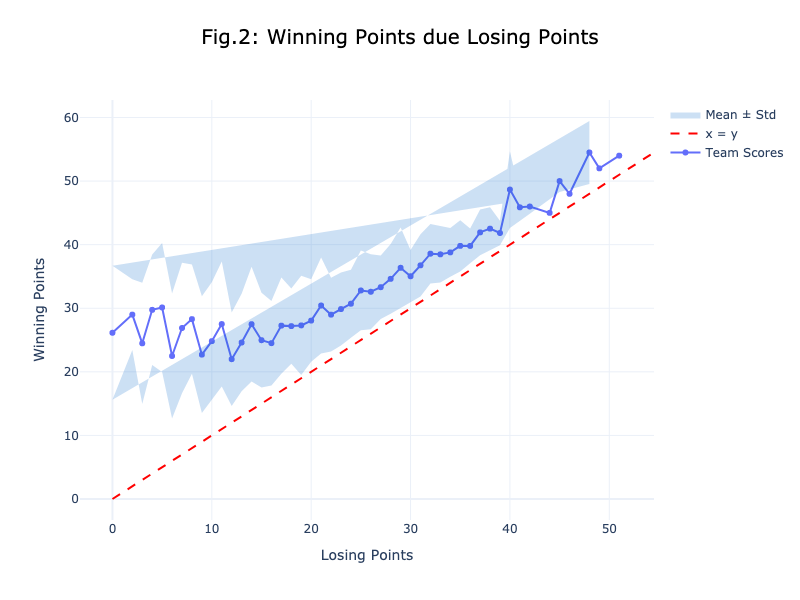

In [22]:
# Group by abs_score_differential_post and calculate average winning_team_score
grouped_data = nfl_per_game_df.groupby("losing_team_score").agg(
    avg_winning_team_score=("winning_team_score", "mean"),
    std_winning_team_score=("winning_team_score", "std")
).reset_index()

# Create scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=grouped_data["losing_team_score"],
    y=grouped_data["avg_winning_team_score"],
    mode="lines+markers",
    name="Team Scores"
))

# Add x=y line
min_val = min(grouped_data["losing_team_score"].min(), grouped_data["avg_winning_team_score"].min())
max_val = max(grouped_data['losing_team_score'].max(), grouped_data['avg_winning_team_score'].max())
fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='x = y'
))

# Group by abs_score_differential_post and calculate average winning_team_score
# Calculate bounds for the shaded region
grouped_data['lower_bound'] = grouped_data['avg_winning_team_score'] - grouped_data['std_winning_team_score']
grouped_data['upper_bound'] = grouped_data['avg_winning_team_score'] + grouped_data['std_winning_team_score']
# Add shaded area for mean ± std
fig.add_trace(go.Scatter(
    x=grouped_data['losing_team_score'],
    y=grouped_data['upper_bound'],
    mode='lines',
    line=dict(width=0, color='rgba(0,100,200,0.2)'),  # Transparent upper bound
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=grouped_data['losing_team_score'],
    y=grouped_data['lower_bound'],
    mode='lines',
    line=dict(width=0, color='rgba(0,100,200,0.2)'),  # Transparent lower bound
    fill='tonexty',  # Fill area between lower and upper bounds
    fillcolor='rgba(0,100,200,0.2)',
    showlegend=True,
    name='Mean ± Std'
))
# Plot
fig.update_layout(
    title=dict(text="Fig.2: Winning Points due Losing Points", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis_title="Losing Points",
    yaxis_title="Winning Points",
    template="plotly_white"
)
fig.show()

In [23]:
nfl_per_game_per_team_per_wp = (
    nfl_df[ nfl_df['posteam'] != '']
    .groupby([
        'game_id', 'posteam', 'wp',
    ])
    .agg({
        'epa': 'mean',
    })
    .reset_index()
)

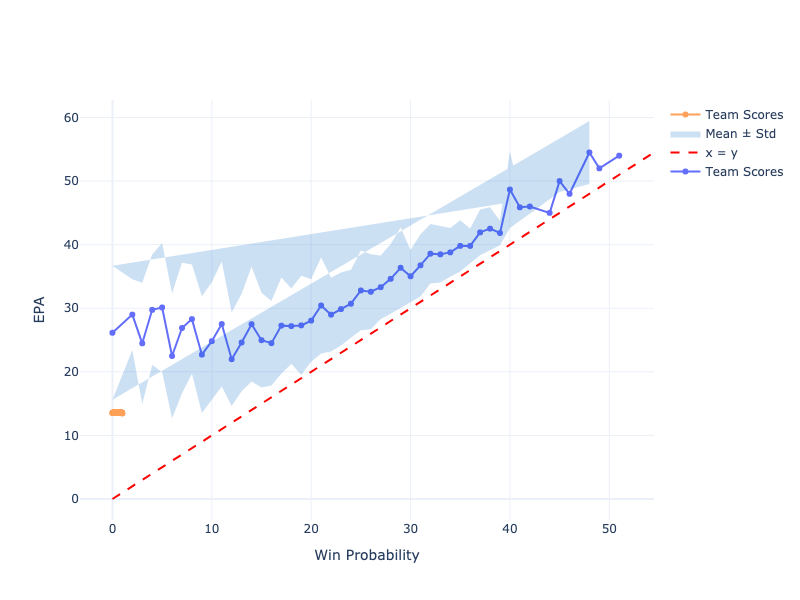

In [24]:

# Group by abs_score_differential_post and calculate average winning_team_score
nfl_per_game_per_team_per_wp['wp_bin'] = (nfl_per_game_per_team_per_wp['wp'] * 100).round() /100
nfl_per_game_per_team_per_wp['abs_epa'] = nfl_per_game_per_team_per_wp['epa'] + abs(min(nfl_per_game_per_team_per_wp['epa']))
grouped_data = nfl_per_game_per_team_per_wp.groupby('wp_bin').agg(
    avg_abs_epa=('abs_epa', 'mean')
).reset_index()


fig.add_trace(go.Scatter(
    x=grouped_data['wp_bin'],
    y=grouped_data['avg_abs_epa'],
    mode='lines+markers',
    name='Team Scores'
))

# Update layout
fig.update_layout(
    title="",
    xaxis_title="Win Probability",
    yaxis_title="EPA",
    template="plotly_white"
)
# Show the plot
fig.show()

## Cooking 🧑‍🍳
---


## Credits
---
* Assistants: Since content, images,

---
## To be continued ...